In [1]:
import serial
import time
import numpy
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
ERROR_CODE = {
    0x00: '操作成功',
    0x01: '操作失败',
    0x04: '指纹数据库已满',
    0x05: '无此用户',
    0x06: '用户已存在',
    0x07: '指纹已存在 ',
    0x08: '采集超时'
}

In [4]:
serialPort = "COM6"  # 串口
baudRate = 9600  # 波特率
ser = serial.Serial(serialPort, baudRate, timeout=0.5)

In [4]:
a = 'F5 09 00 00 00 00 09 F5'
print(list(map(lambda x: int(x, 16), a.split(' '))))  # 十进制
print(','.join(['0x' + i for i in a.split(' ')]))    # 16 进制

[245, 9, 0, 0, 0, 0, 9, 245]
0xF5,0x09,0x00,0x00,0x00,0x00,0x09,0xF5


In [5]:
# 测试连接

# 16 进制发送与 十进制 发送效果一样， 不用 bytes(0) 也一样
order = bytes([245, 9, 0, 0, 0, 0, 9, 245])
# order = [0xF5,0x09,0x00,0x00,0x00,0x00,0x09,0xF5]

if ser.isOpen():
    ser.flushInput()
    ser.write(order)
    time.sleep(1)
    num = ser.in_waiting
    if num > 0:
        response = ser.read(num)
        print(response)
#         time = datetime.datetime.now()
#         time = time.strftime('%Y-%m-%d %H:%M:%S')
    else:
        print(num)
else:
    print('Not Open!')



b'\xf5\t\x00\x05\x00\x00\x0c\xf5'


In [6]:
ser.in_waiting

0

In [5]:
def send(order, wait=False):
    if ser.isOpen():
        ser.flushInput()
        ser.write(order)
        time.sleep(1)
        num = ser.in_waiting
        if num > 0:
            response = ser.read(num)
            # print(response)
            return response
    #         time = datetime.datetime.now()
    #         time = time.strftime('%Y-%m-%d %H:%M:%S')
        if wait:
            print('Waitting.')
            # 等待录入
            while not ser.in_waiting:
                time.sleep(.5)
            # 等待上传
            time.sleep(10.2)
            num = ser.in_waiting
            return ser.read(num)
    else:
        print('Not Open!')


def build_request(data):
    # 添加边界符和校验位
    order = [0xF5, *data, calculate_check(data), 0xF5]
    return order


def parse_response(response):
    # 去边界符和校验位
    if len(response) == 8:
        # return [hex(i)[2:] for i in response[1:-2]]
        return response[1:-2]

    elif len(response) > 8:
        # header = [hex(i)[2:] for i in response[1:7]]
        # body = [hex(i)[2:] for i in response[9:-2]]
        header = response[1:7]
        body = response[9:-2]

        return header, body


# 计算校验和
def calculate_check(data):
    check = data[0]
    for i in data[1:]:
        check ^= i
    return check

### 休眠 谨慎操作

In [ ]:
order = [0xF5, 0x2C, 0, 0, 0, 0, 0x2c, 0xF5]

ser.write(order)
time.sleep(0.5)
num = ser.in_waiting

if num > 0:
    response = ser.read(num)
    print(response)

    # 应答报文与 发送一致

### 设置/读取指纹添加模式

In [8]:
request = [0x2D, 0 ,0 ,1, 0]
order = build_request(request)

response = send(order)
if response:
    header = parse_response(response)
    print(header)
    print(ERROR_CODE[header[-2]])

b'-\x00\x01\x00\x00'
操作成功


### 采集图像并上传

In [6]:
request = [0x24, 0, 0, 0, 0]
request = build_request(request)

response = send(request, wait=True)
len(response)

Waitting.


9187

In [7]:
header, body = parse_response(response)
print(ERROR_CODE[header[-2]], len(body))

操作成功 9176


In [8]:
def parse_fp_pic(body_data):
    """
    body_data: 返回数据的数据包部分
    return: 灰度图的三维数组
    """
    if len(body_data) != 9176:
        print('数据异常，无法解析')
        return
    gray_array = []
    for i in body_data:
        later = i
        former = (i << 4) & 0xFF

        gray_array.append([former] * 3)
        gray_array.append([later] * 3)

#         gray_array.append(former)
#         gray_array.append(later)
    gray_array = numpy.array(gray_array).reshape((148, 124, 3))

    return gray_array

In [9]:
pic = parse_fp_pic(body)
pic.shape

(148, 124, 3)

### 显示、保存图片

In [10]:
cd C:\Users\Administrator\Desktop

C:\Users\Administrator\Desktop


#### - 

In [11]:
from scipy import misc
misc.imsave('out.jpg', pic)

d:\softinstall\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [69]:
import imageio
imageio.imwrite('out.jpg', pic)

Lossy conversion from int32 to uint8. Range [0, 184]. Convert image to uint8 prior to saving to suppress this warning.


#### - 

In [2]:
import cv2

cv2.imshow('gray', pic)

NameError: name 'pic' is not defined

#### - 

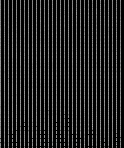

In [62]:
im = Image.fromarray(pic, 'L')
im

In [29]:
im.save('temp.png')

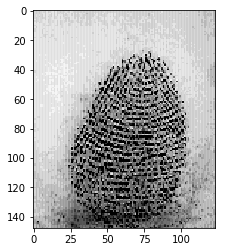

In [63]:
plt.imshow(pic, cmap='Greys_r')

In [65]:
plt.savefig('aaaaaa.jpg', cmap='Greys_r')

<Figure size 432x288 with 0 Axes>

In [ ]:
# a=np.zeros((256,256,3))
# b = Image.fromarray(a, mode='RGB')
# b.show()
 
# img = np.array(Image.open("lena.jpg"))
# img = Image.fromarray(img, mode='RGB')
# img.show()